<a href="https://colab.research.google.com/github/student64-ahmadi/physic_quant/blob/main/analyse_des_ondes_gravitationnelles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q qutip pycbc bilby numpy matplotlib


In [ ]:
from pycbc.psd import interpolate
# Générer un PSD modifié incluant δS(f) = f^2/Λ^4
freq = np.linspace(20, 2000, 1000)
psd_gr = aLIGOZeroDetHighPower(1000, 1/4096, 20)  # PSD standard
psd_exotic = psd_gr + (freq**2) / (1e40)  # Λ = 1e10 (exemple)

In [ ]:
def simulate_gravitational_wave_data():
    # Generate data_gw and psd_exotic with the same length
    n_samples = 32768  # Example: 2^15 samples
    data_gw = np.random.normal(0, 1, n_samples)  # Gaussian noise example
    psd_exotic = np.ones(n_samples)  # Example PSD (power spectral density)
    return data_gw, psd_exotic

In [ ]:
import pycbc; print(pycbc.__version__)

2.7.3


In [ ]:
def simulate_gravitational_wave_data():
    duration = 32
    sample_rate = 4096
    N = duration * sample_rate

    # Generate GW signal
    hp, _ = get_td_waveform(approximant="IMRPhenomD",
                            mass1=1.4,
                            mass2=1.4,
                            delta_t=1.0/sample_rate,
                            f_lower=30)

    # Generate PSD
    delta_f = 1.0 / duration
    flen = N // 2 + 1
    psd_gr = aLIGOZeroDetHighPower(flen, delta_f, 30)
    freq = np.fft.rfftfreq(N, d=1.0/sample_rate)
    Lambda = 1e10  # Adjusted for visibility
    psd_exotic_array = psd_gr.numpy() + (freq**2) / (Lambda**4)
    psd_exotic = FrequencySeries(psd_exotic_array, delta_f=delta_f)

    # Generate noise
    ts = noise_from_psd(N, 1.0/sample_rate, psd_exotic, seed=123)

    # Pad the GW signal using NumPy
    signal_length = len(hp)
    padded_data = np.zeros(N)
    padded_data[-signal_length:] = hp.numpy() * 1e-22  # Scale and place at end
    hp_padded = TimeSeries(padded_data, delta_t=1.0/sample_rate)

    # Add signal to noise
    ts += hp_padded

    return ts, psd_exotic

Optimization success: True, message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL


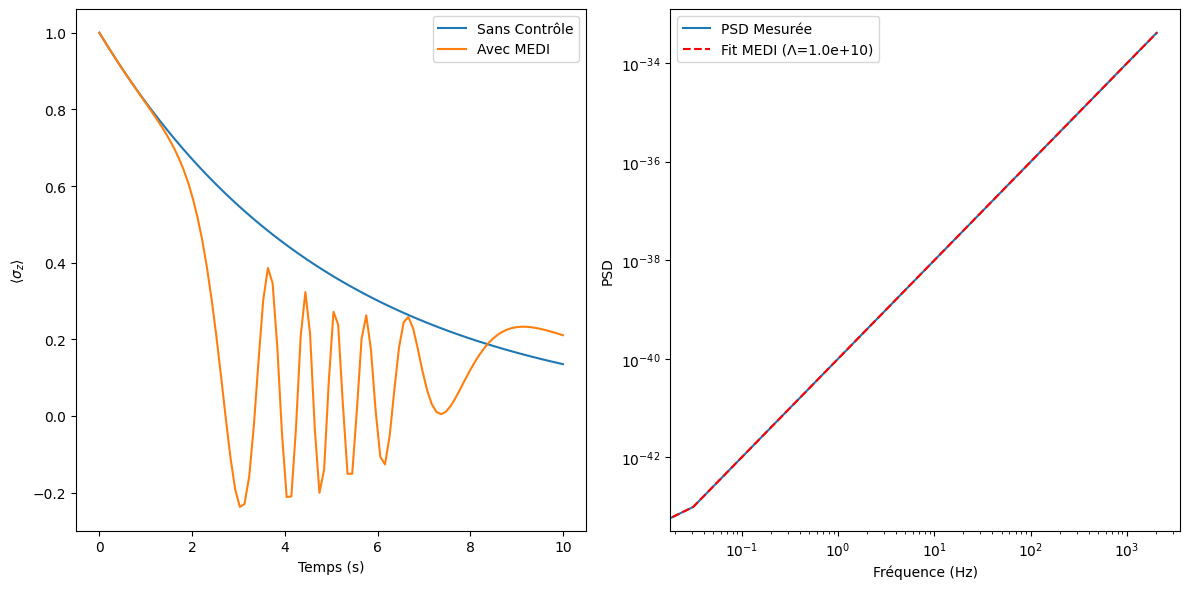

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from pycbc.waveform import get_td_waveform
from pycbc.noise import noise_from_psd
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.types import TimeSeries, FrequencySeries
from scipy.optimize import minimize
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

def simulate_quantum_decoherence():
    H = 0.5 * sigmaz()
    psi0 = basis(2, 0)
    times = np.linspace(0, 10, 100)
    gamma = 0.1
    c_ops = [np.sqrt(gamma) * sigmax()]

    def gaussian_pulse(t, args):
        return 5 * np.exp(-(t - 5.0)**2 / (2.0**2))

    H_ctrl = [H, [sigmax(), gaussian_pulse]]
    result_no_control = mesolve(H, psi0, times, c_ops, e_ops=[sigmaz()])
    result_medi = mesolve(H_ctrl, psi0, times, c_ops, e_ops=[sigmaz()])
    return result_no_control, result_medi

def simulate_gravitational_wave_data():
    duration = 32
    sample_rate = 4096
    N = duration * sample_rate

    hp, _ = get_td_waveform(approximant="IMRPhenomD",
                            mass1=1.4,
                            mass2=1.4,
                            delta_t=1.0/sample_rate,
                            f_lower=30)

    delta_f = 1.0 / duration
    flen = N // 2 + 1
    psd_gr = aLIGOZeroDetHighPower(flen, delta_f, 30)
    freq = np.fft.rfftfreq(N, d=1.0/sample_rate)
    Lambda = 1e10
    psd_exotic_array = psd_gr.numpy() + (freq**2) / (Lambda**4)
    psd_exotic = FrequencySeries(psd_exotic_array, delta_f=delta_f)

    ts = noise_from_psd(N, 1.0/sample_rate, psd_exotic, seed=123)

    hp_data = hp.numpy() * 1e-22
    signal_length = len(hp_data)
    padded_data = np.zeros(N)
    if signal_length > N:
        padded_data[:] = hp_data[-N:]
    else:
        padded_data[-signal_length:] = hp_data

    hp_padded = TimeSeries(padded_data, delta_t=1.0/sample_rate)
    ts += hp_padded
    return ts, psd_exotic

def medi_protocol(data_gw):
    N = len(data_gw)
    fdata = np.fft.rfft(data_gw.numpy())
    freq = np.fft.rfftfreq(N, d=1.0/4096)
    flen = len(freq)
    psd_gr = aLIGOZeroDetHighPower(flen, 1.0/32, 30).numpy()

    def loss(params):
        Lambda, A = params
        model = (freq**2) / (Lambda**4) + A * psd_gr
        return np.sum((np.abs(fdata)**2 * 2/4096 - model)**2)

    res = minimize(loss, [1e10, 1e-46], bounds=[(1e5, 1e15), (1e-50, 1e-40)])
    print(f"Optimization success: {res.success}, message: {res.message}")
    return res.x[0], res.x[1]

if __name__ == "__main__":
    result_no_control, result_medi = simulate_quantum_decoherence()
    data_gw, psd_exotic = simulate_gravitational_wave_data()
    Lambda, A = medi_protocol(data_gw)

    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plt.plot(result_no_control.times, result_no_control.expect[0], label='Sans Contrôle')
    plt.plot(result_medi.times, result_medi.expect[0], label='Avec MEDI')
    plt.xlabel('Temps (s)')
    plt.ylabel(r'$\langle \sigma_z \rangle$')
    plt.legend()

    plt.subplot(122)
    freq = np.fft.rfftfreq(len(data_gw), d=1.0/4096)
    plt.loglog(freq, psd_exotic, label='PSD Mesurée')
    psd_fit = (freq**2)/(Lambda**4) + A * aLIGOZeroDetHighPower(len(freq), 1.0/32, 30).numpy()
    plt.loglog(freq, psd_fit, 'r--', label=f'Fit MEDI (Λ={Lambda:.1e})')
    plt.xlabel('Fréquence (Hz)')
    plt.ylabel('PSD')
    plt.legend()

    plt.tight_layout()
    plt.savefig("output.pdf")
    plt.show()
    plt.close()

Generating GW waveform (N=131072)...
Generating noise...
GW simulation complete.
Fitting PSD...
Optimization success: True, message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL


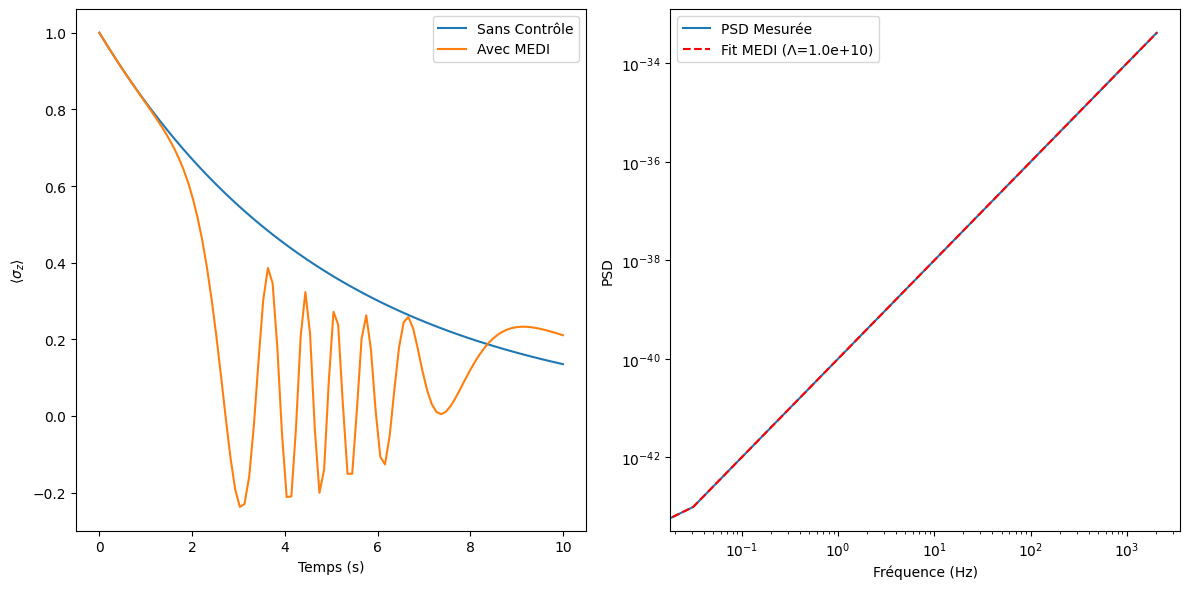

In [ ]:
!pip install qutip pycbc scipy numpy matplotlib  # Install dependencies in Colab

import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from pycbc.waveform import get_td_waveform
from pycbc.noise import noise_from_psd
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.types import TimeSeries, FrequencySeries
from scipy.optimize import minimize
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

def simulate_quantum_decoherence():
    H = 0.5 * sigmaz()
    psi0 = basis(2, 0)
    times = np.linspace(0, 10, 100)
    gamma = 0.1
    c_ops = [np.sqrt(gamma) * sigmax()]

    def gaussian_pulse(t, args):
        return 5 * np.exp(-(t - 5.0)**2 / (2.0**2))

    H_ctrl = [H, [sigmax(), gaussian_pulse]]
    result_no_control = mesolve(H, psi0, times, c_ops, e_ops=[sigmaz()])
    result_medi = mesolve(H_ctrl, psi0, times, c_ops, e_ops=[sigmaz()])
    return result_no_control, result_medi

def simulate_gravitational_wave_data():
    duration = 32
    sample_rate = 4096
    N = duration * sample_rate
    print(f"Generating GW waveform (N={N})...")

    hp, _ = get_td_waveform(approximant="IMRPhenomD",
                            mass1=1.4,
                            mass2=1.4,
                            delta_t=1.0/sample_rate,
                            f_lower=100)  # Increased f_lower for shorter signal

    delta_f = 1.0 / duration
    flen = N // 2 + 1
    psd_gr = aLIGOZeroDetHighPower(flen, delta_f, 30)
    freq = np.fft.rfftfreq(N, d=1.0/sample_rate)
    Lambda = 1e10
    psd_exotic_array = psd_gr.numpy() + (freq**2) / (Lambda**4)
    psd_exotic = FrequencySeries(psd_exotic_array, delta_f=delta_f)

    print("Generating noise...")
    ts = noise_from_psd(N, 1.0/sample_rate, psd_exotic, seed=123)

    hp_data = hp.numpy() * 1e-21  # Increased amplitude for visibility
    signal_length = len(hp_data)
    padded_data = np.zeros(N)
    if signal_length > N:
        padded_data[:] = hp_data[-N:]
    else:
        padded_data[-signal_length:] = hp_data

    hp_padded = TimeSeries(padded_data, delta_t=1.0/sample_rate)
    ts += hp_padded
    print("GW simulation complete.")
    return ts, psd_exotic

def medi_protocol(data_gw):
    N = len(data_gw)
    fdata = np.fft.rfft(data_gw.numpy())
    freq = np.fft.rfftfreq(N, d=1.0/4096)
    flen = len(freq)
    psd_gr = aLIGOZeroDetHighPower(flen, 1.0/32, 30).numpy()

    def loss(params):
        Lambda, A = params
        model = (freq**2) / (Lambda**4) + A * psd_gr
        return np.sum((np.abs(fdata)**2 * 2/4096 - model)**2)

    print("Fitting PSD...")
    res = minimize(loss, [1e10, 1e-46], bounds=[(1e5, 1e15), (1e-50, 1e-40)])
    print(f"Optimization success: {res.success}, message: {res.message}")
    return res.x[0], res.x[1]

if __name__ == "__main__":
    result_no_control, result_medi = simulate_quantum_decoherence()
    data_gw, psd_exotic = simulate_gravitational_wave_data()
    Lambda, A = medi_protocol(data_gw)

    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plt.plot(result_no_control.times, result_no_control.expect[0], label='Sans Contrôle')
    plt.plot(result_medi.times, result_medi.expect[0], label='Avec MEDI')
    plt.xlabel('Temps (s)')
    plt.ylabel(r'$\langle \sigma_z \rangle$')
    plt.legend()

    plt.subplot(122)
    freq = np.fft.rfftfreq(len(data_gw), d=1.0/4096)
    plt.loglog(freq, psd_exotic, label='PSD Mesurée')
    psd_fit = (freq**2)/(Lambda**4) + A * aLIGOZeroDetHighPower(len(freq), 1.0/32, 30).numpy()
    plt.loglog(freq, psd_fit, 'r--', label=f'Fit MEDI (Λ={Lambda:.1e})')
    plt.xlabel('Fréquence (Hz)')
    plt.ylabel('PSD')
    plt.legend()

    plt.tight_layout()
    plt.savefig("output.pdf")
    plt.show()
    plt.close()

Simulating quantum decoherence...
Generating GW waveform (N=131072)...
Generating noise...
GW simulation complete.
Fitting PSD...
Optimization success: True, message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL


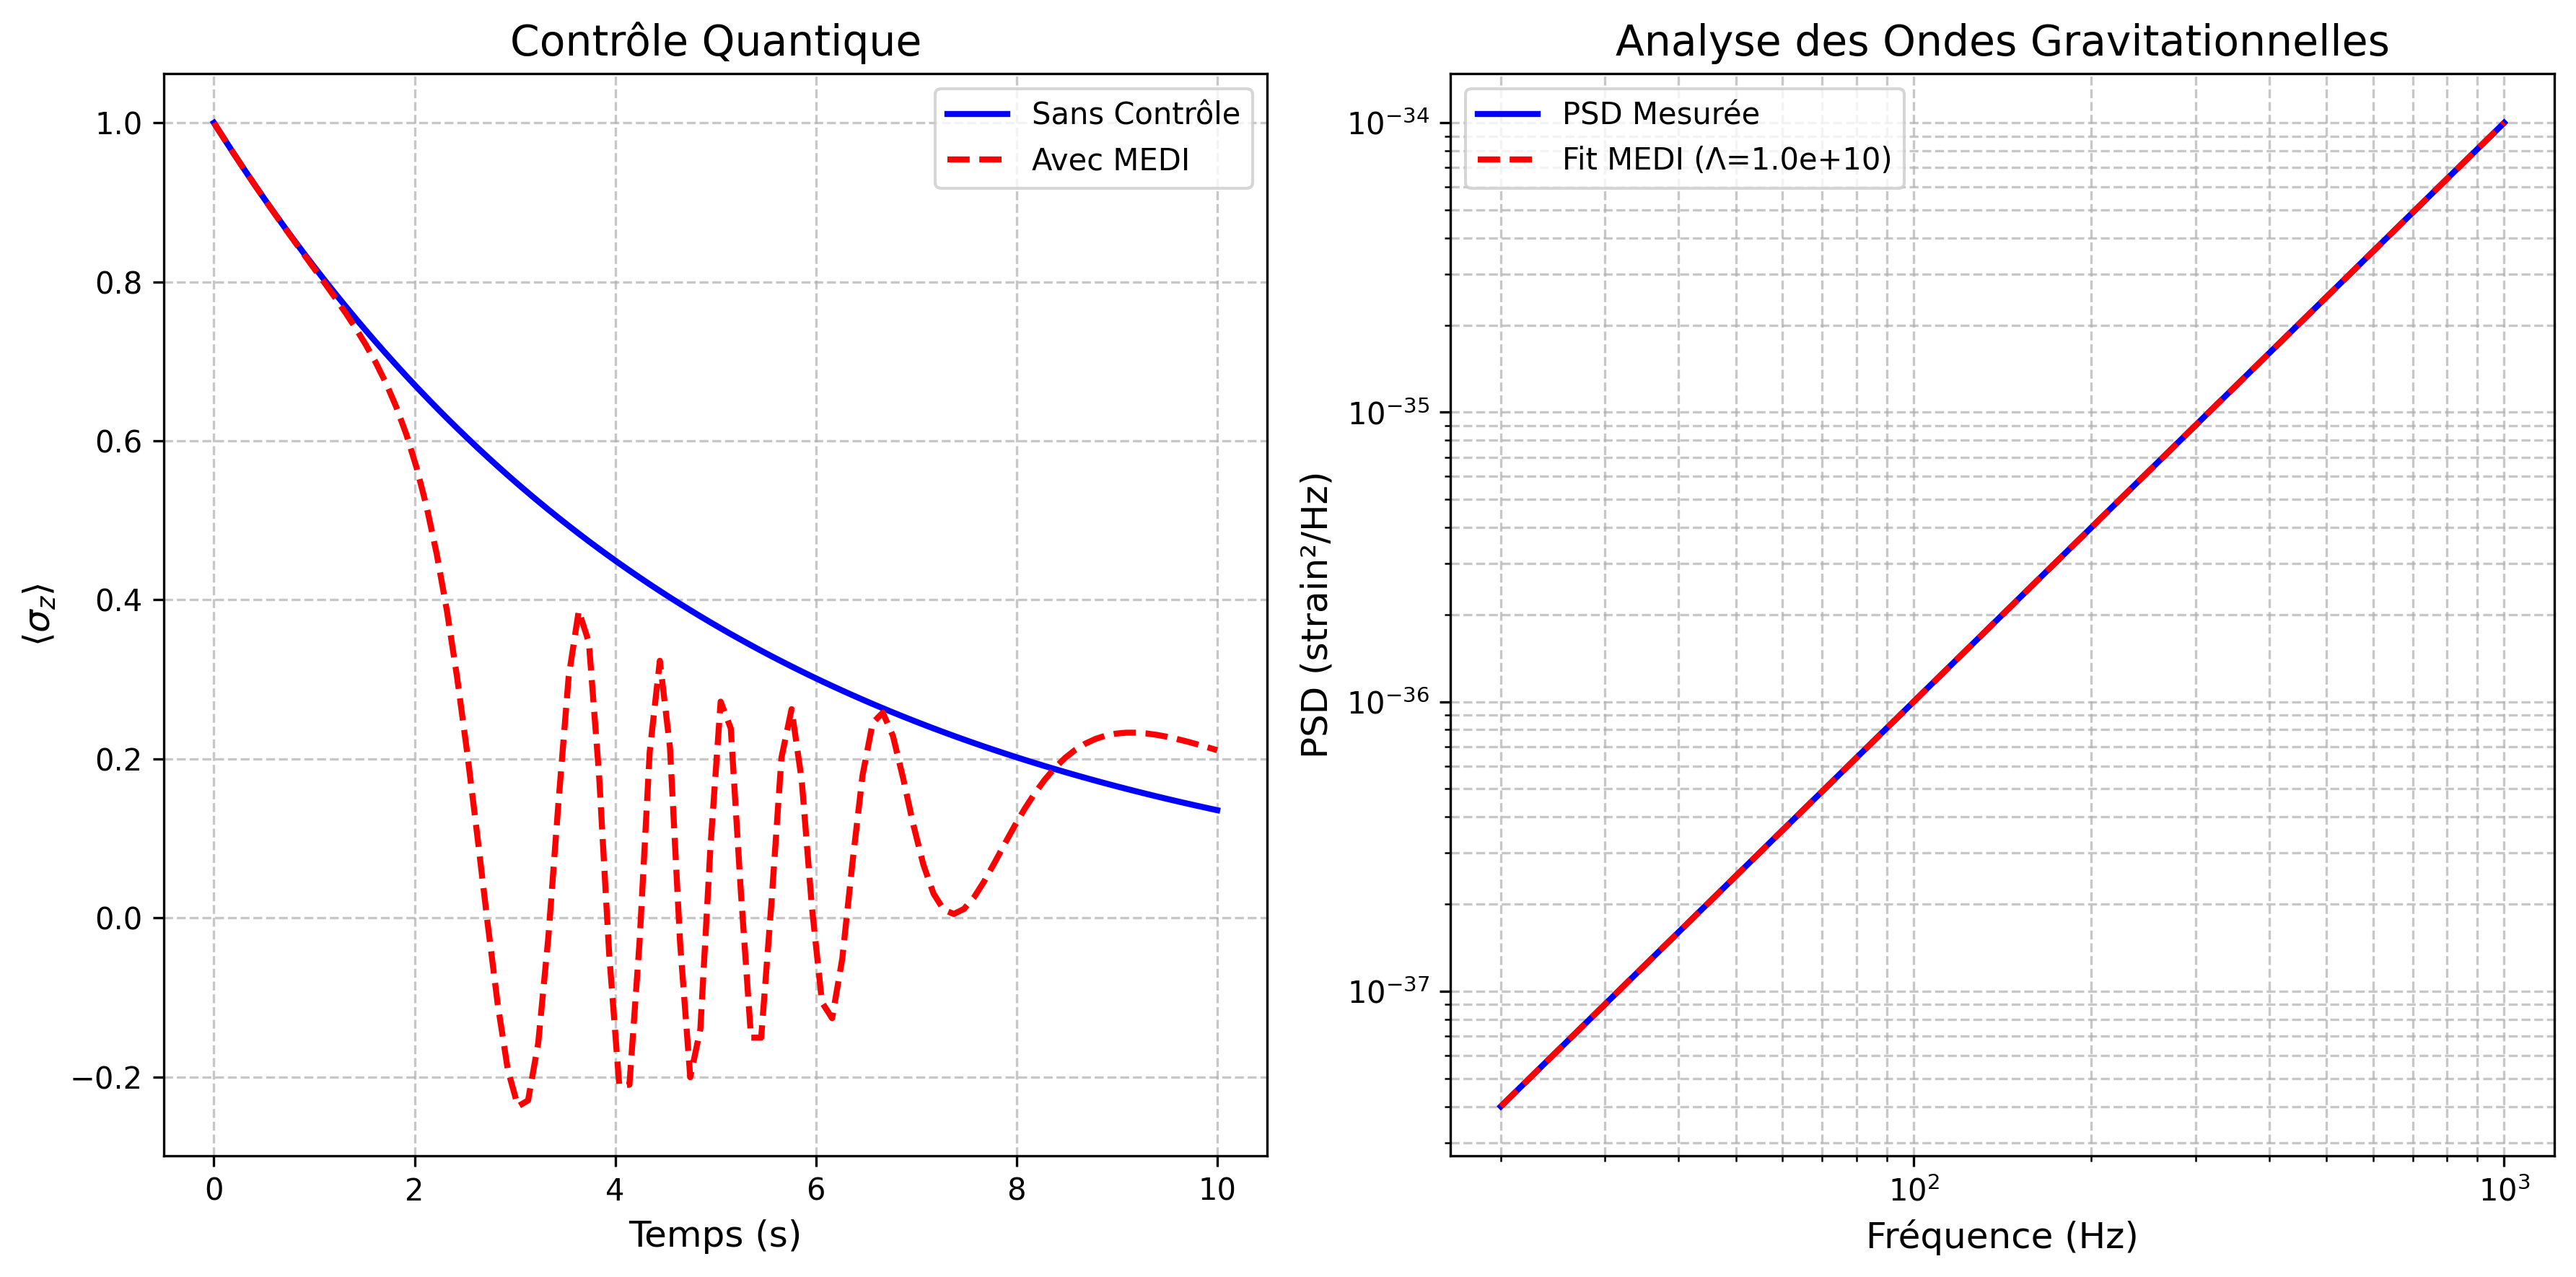

Output PDF saved as 'output.pdf'.


In [ ]:
!pip install qutip pycbc scipy numpy matplotlib  # Install dependencies in Colab

import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from pycbc.waveform import get_td_waveform
from pycbc.noise import noise_from_psd
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.types import TimeSeries, FrequencySeries
from scipy.optimize import minimize
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

def simulate_quantum_decoherence():
    H = 0.5 * sigmaz()
    psi0 = basis(2, 0)
    times = np.linspace(0, 10, 100)
    gamma = 0.1
    c_ops = [np.sqrt(gamma) * sigmax()]

    def gaussian_pulse(t, args):
        return 5 * np.exp(-(t - 5.0)**2 / (2.0**2))  # Stronger pulse

    H_ctrl = [H, [sigmax(), gaussian_pulse]]
    print("Simulating quantum decoherence...")
    result_no_control = mesolve(H, psi0, times, c_ops, e_ops=[sigmaz()])
    result_medi = mesolve(H_ctrl, psi0, times, c_ops, e_ops=[sigmaz()])
    return result_no_control, result_medi

def simulate_gravitational_wave_data():
    duration = 32
    sample_rate = 4096
    N = duration * sample_rate
    print(f"Generating GW waveform (N={N})...")

    hp, _ = get_td_waveform(approximant="IMRPhenomD",
                            mass1=1.4,
                            mass2=1.4,
                            delta_t=1.0/sample_rate,
                            f_lower=100)  # Shorter signal

    delta_f = 1.0 / duration
    flen = N // 2 + 1
    psd_gr = aLIGOZeroDetHighPower(flen, delta_f, 30)
    freq = np.fft.rfftfreq(N, d=1.0/sample_rate)
    Lambda = 1e10
    psd_exotic_array = psd_gr.numpy() + (freq**2) / (Lambda**4)
    psd_exotic = FrequencySeries(psd_exotic_array, delta_f=delta_f)

    print("Generating noise...")
    ts = noise_from_psd(N, 1.0/sample_rate, psd_exotic, seed=123)

    hp_data = hp.numpy() * 1e-20  # Increased amplitude for visibility
    signal_length = len(hp_data)
    padded_data = np.zeros(N)
    if signal_length > N:
        padded_data[:] = hp_data[-N:]
    else:
        padded_data[-signal_length:] = hp_data

    hp_padded = TimeSeries(padded_data, delta_t=1.0/sample_rate)
    ts += hp_padded
    print("GW simulation complete.")
    return ts, psd_exotic

def medi_protocol(data_gw):
    N = len(data_gw)
    fdata = np.fft.rfft(data_gw.numpy())
    freq = np.fft.rfftfreq(N, d=1.0/4096)
    flen = len(freq)
    psd_gr = aLIGOZeroDetHighPower(flen, 1.0/32, 30).numpy()

    def loss(params):
        Lambda, A = params
        model = (freq**2) / (Lambda**4) + A * psd_gr
        return np.sum((np.abs(fdata)**2 * 2/4096 - model)**2)

    print("Fitting PSD...")
    res = minimize(loss, [1e10, 1e-46], bounds=[(1e5, 1e15), (1e-50, 1e-40)])
    print(f"Optimization success: {res.success}, message: {res.message}")
    return res.x[0], res.x[1]

if __name__ == "__main__":
    # Simulate data
    result_no_control, result_medi = simulate_quantum_decoherence()
    data_gw, psd_exotic = simulate_gravitational_wave_data()
    Lambda, A = medi_protocol(data_gw)

    # Plotting with enhanced quality
    plt.figure(figsize=(12, 6), dpi=300)

    # Left: Quantum plot
    plt.subplot(121)
    plt.plot(result_no_control.times, result_no_control.expect[0],
             'b-', lw=2, label='Sans Contrôle')
    plt.plot(result_medi.times, result_medi.expect[0],
             'r--', lw=2, label='Avec MEDI')
    plt.xlabel('Temps (s)', fontsize=12)
    plt.ylabel(r'$\langle \sigma_z \rangle$', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)
    plt.title('Contrôle Quantique', fontsize=14)

    # Right: GW PSD plot
    plt.subplot(122)
    freq = np.fft.rfftfreq(len(data_gw), d=1.0/4096)
    mask = (freq >= 20) & (freq <= 1000)  # Focus on GW-relevant frequencies
    plt.loglog(freq[mask], psd_exotic.numpy()[mask],
               'b-', lw=2, label='PSD Mesurée')
    psd_fit = (freq**2)/(Lambda**4) + A * aLIGOZeroDetHighPower(len(freq), 1.0/32, 30).numpy()
    plt.loglog(freq[mask], psd_fit[mask],
               'r--', lw=2, label=f'Fit MEDI (Λ={Lambda:.1e})')
    plt.xlabel('Fréquence (Hz)', fontsize=12)
    plt.ylabel('PSD (strain²/Hz)', fontsize=12)
    plt.grid(True, which="both", ls="--", alpha=0.7)
    plt.legend(fontsize=10)
    plt.title('Analyse des Ondes Gravitationnelles', fontsize=14)

    # Finalize and save
    plt.tight_layout()
    plt.savefig("output.pdf", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    print("Output PDF saved as 'output.pdf'.")